# Semi-supervised Graph Node Classification

This notebook goes through the "Cora" dataset example from [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html). 

## Dependencies

Let's load in the dependencies.

In [80]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## About the **Cora** dataset.

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. [Source.](https://paperswithcode.com/dataset/cora)

In [81]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

First, let us see how many different classes the Cora dataset contains.

In [83]:
dataset.num_classes

7

Let's make sure we have 1433 edge features (i.e. which words each article contains.)

In [95]:
dataset.num_node_features

1433

We can also look at the data matrix.

In [110]:
data.x.shape

torch.Size([2708, 1433])

How many does the training set, validation set and test set contain?

In [104]:
data = dataset[0]
data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item()

(140, 500, 1000)

# Implementing a Graph Convolutional Networks

Define the GCN.

In [111]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Set the device, model, data and optimizer.

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Let's train the model.

In [123]:
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Let us also evaluate the model:

In [125]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8030


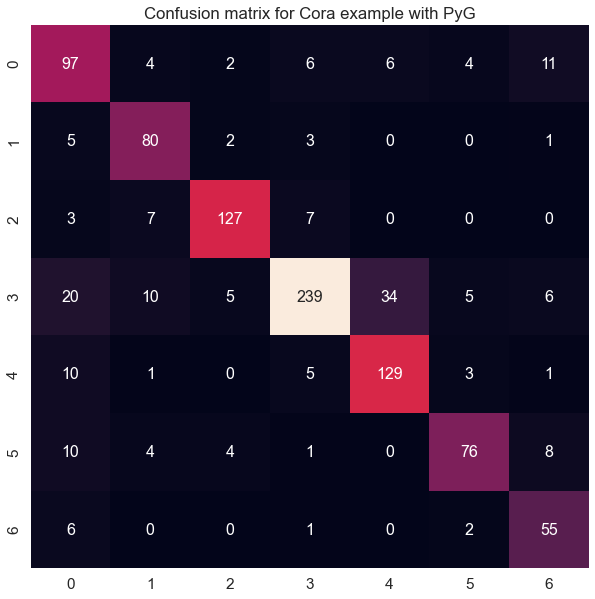

In [126]:
cm = confusion_matrix(y_true = data.y[data.test_mask], y_pred = pred[data.test_mask])
df_cm = pd.DataFrame(cm, range(7), range(7))


plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False) # font size
plt.title('Confusion matrix for Cora example with PyG')
plt.show()